# Molecular mechnism: Drivers of Rapid Cell Fate Transitions

One intriguing phenomenon observed in hematopoiesis is that commitment to and appearance of the Meg lineage occurs more rapidly than other lineages (Sanjuan-Pla et al., 2013; Yamamoto et al., 2013). However, the mechanisms underlying this process remain elusive. To mechanistically dissect this finding, we focused on all cell types derived from the MEP-like lineage.

In this tutorial, we will guide you to
- learn vector field and manually select fixed points
- visualize topography with computed fixed points
- compute pseudotime (potential)
- visualize vector field pseudotime of cell types


Import relevant packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import dynamo as dyn

dyn.configuration.set_figure_params('dynamo', background='white')
dyn.pl.style(font_path='Arial')
dyn.get_all_dependencies_version()

%load_ext autoreload
%autoreload 2

Using already downloaded Arial font from: /tmp/dynamo_arial.ttf
Registered custom font as: Arial


 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



package,umap-learn,typing-extensions,tqdm,statsmodels,setuptools,session-info,seaborn,scipy,requests,pynndescent,pre-commit,pandas,openpyxl,numdifftools,numba,networkx,mudata,matplotlib,loompy,leidenalg,igraph,dynamo-release,colorcet,anndata
version,0.5.7,4.13.2,4.67.1,0.14.4,79.0.0,1.0.1,0.13.2,1.11.4,2.32.3,0.5.13,4.2.0,2.2.3,3.1.5,0.9.41,0.60.0,3.4.2,0.3.1,3.10.3,3.0.8,0.10.2,0.11.8,1.4.2rc1,3.1.0,0.11.4


In [2]:
adata_labeling = dyn.sample_data.hematopoiesis()

|-----> Downloading processed hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis.h5ad
|-----> in progress: 99.0945%|-----> [download] completed [44.2869s]


take a glance at what is in `adata` object. All observations, embedding layers and other data in `adata` are computed within `dynamo`. Please refer to other dynamo tutorials regarding how to obtain these values from metadata and raw new/total and (or) raw spliced/unspliced gene expression values.

## A schematic of leveraging differential geometry 
- ranking genes (using either raw or absolute values) across all cells or in each cell group/state
- gene set enrichment, network construction, and visualization
- identifying top toggle-switch pairs driving cell fate bifurcations

![fig5_A](images/fig5_a.png)

## Visualize topography


### Lineage tree of hematopoiesis, lumped automatically from the vector field built in the UMAP space

![fig5_C](images/fig5_C.png)


### The reconstructed vector field and associated fixed points. 
The color of digits in each node reflects the type of fixed point: red, emitting fixed point; black, absorbing fixed point. The color of the numbered nodes corresponds to the confidence of the fixed points.

#### Manually select good fixed points found by topography

In [3]:
adata_labeling.uns["VecFld_umap"].keys()

dict_keys(['C', 'E_traj', 'P', 'V', 'VFCIndex', 'X', 'X_ctrl', 'X_data', 'Xss', 'Y', 'beta', 'confidence', 'ctrl_idx', 'ftype', 'grid', 'grid_V', 'iteration', 'method', 'nullcline', 'sigma2', 'tecr_traj', 'valid_ind', 'xlim', 'ylim'])

In [4]:
dyn.vf.topography(adata_labeling, n=750, basis="umap")

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

|-----------> plotting with basis key=X_umap


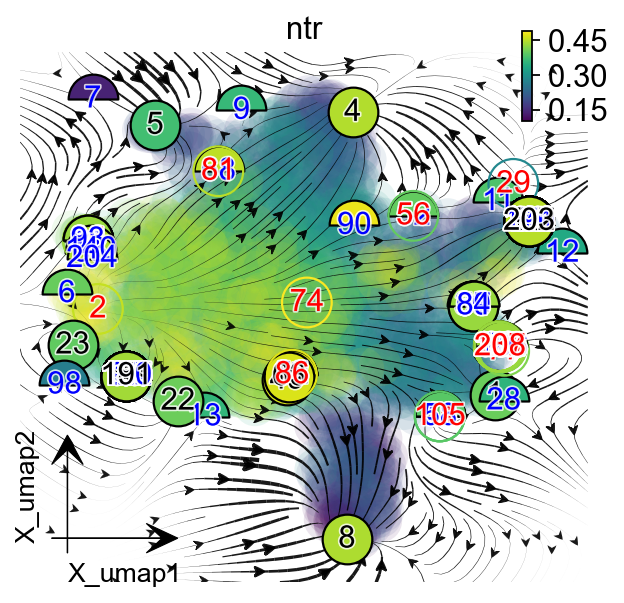

In [7]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    streamline_alpha=0.9,
    s_kwargs_dict={'adjust_legend':True},
    figsize=(4,4)
)


In the resulted dictionary, `Xss` stands for the fixed points coordinates and `ftype` is the specific fixed point type, denoted by integers.  
ftype value mapping:  
- -1: stable
- 0: saddle
- 1: unstable

In [8]:
Xss, ftype = adata_labeling.uns["VecFld_umap"]["Xss"], adata_labeling.uns["VecFld_umap"]["ftype"]
# good_fixed_points = [0, 2, 5, 29, 11, 28] # n=250
good_fixed_points = [2, 8, 1, 195, 4, 5]  # n=750

adata_labeling.uns["VecFld_umap"]["Xss"] = Xss[good_fixed_points]
adata_labeling.uns["VecFld_umap"]["ftype"] = ftype[good_fixed_points]


|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


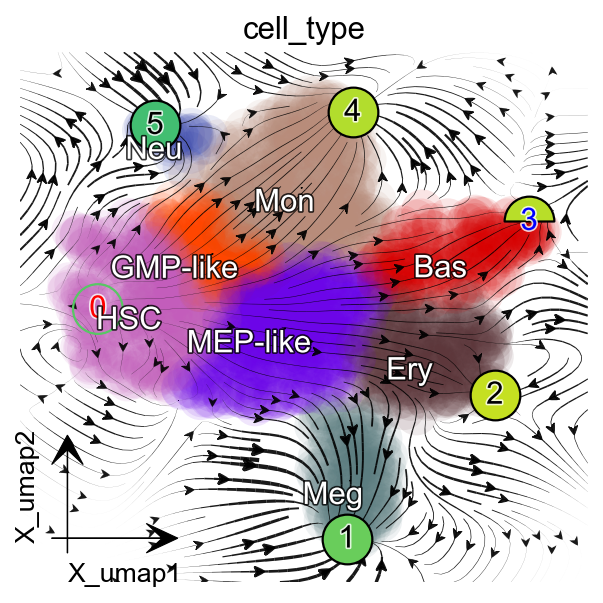

In [10]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    #   color=['pca_ddhodge_potential'],
    color=["cell_type"],
    streamline_alpha=0.9,
    s_kwargs_dict={'adjust_legend':True},
    figsize=(4,4)
)


## Vector field pseudotime

In this section, we will show how to visualize vector field pseudotime with `dynamo`. The vector field pseudotime is calculated based on the velocity transition matrix.

**Define a colormap we will use later**

In [11]:
dynamo_color_dict = {
    "Mon": "#b88c7a",
    "Meg": "#5b7d80",
    "MEP-like": "#6c05e8",
    "Ery": "#5d373b",
    "Bas": "#d70000",
    "GMP-like": "#ff4600",
    "HSC": "#c35dbb",
    "Neu": "#2f3ea8",
}


**Initialize a Dataframe object that we will use to plot with visualization packages such as `sns`**

In [12]:
valid_cell_type = ["HSC", "MEP-like", "Meg", "Ery", "Bas"]
valid_indices = adata_labeling.obs["cell_type"].isin(valid_cell_type)
df = adata_labeling[valid_indices].obs[["pca_ddhodge_potential", "umap_ddhodge_potential", "cell_type"]]
df["cell_type"] = list(df["cell_type"])


### Building a graph, computing divergence and potential with `graph_operators` in `dynamo`

In [13]:
from dynamo.tools.graph_operators import build_graph, div, potential

g = build_graph(adata_labeling.obsp["cosine_transition_matrix"])
ddhodge_div = div(g)
potential_cosine = potential(g, -ddhodge_div)
adata_labeling.obs["cosine_potential"] = potential_cosine


Compute `potential_fp` and store in the dataframe object `df` we created above. Note that `fp` stands for `fokkerplanck` method. Please refer to the `dynamo` cell paper for more details on the related methods.

In [14]:
g = build_graph(adata_labeling.obsp["fp_transition_rate"])
ddhodge_div = div(g)
potential_fp = potential(g, ddhodge_div)


set `potential_fp` and `pseudotime_fp` in adata.obs to visualize potential and time.

In [15]:
adata_labeling.obs["potential_fp"] = potential_fp
adata_labeling.obs["pseudotime_fp"] = -potential_fp


|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


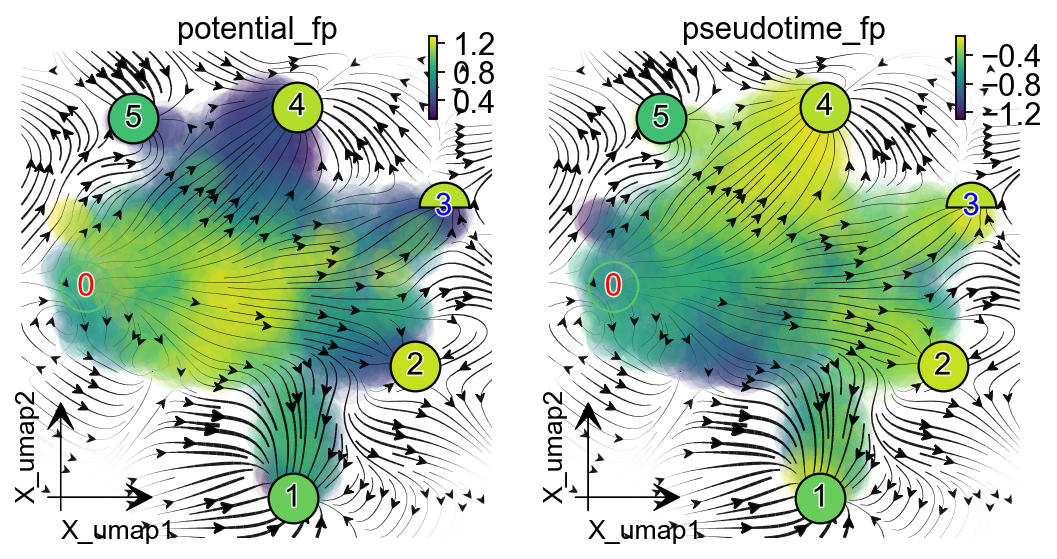

In [16]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    color=["potential_fp", "pseudotime_fp"],
    streamline_alpha=0.9,
    s_kwargs_dict={'adjust_legend':True,'dpi':80},
    figsize=(4,4)
)


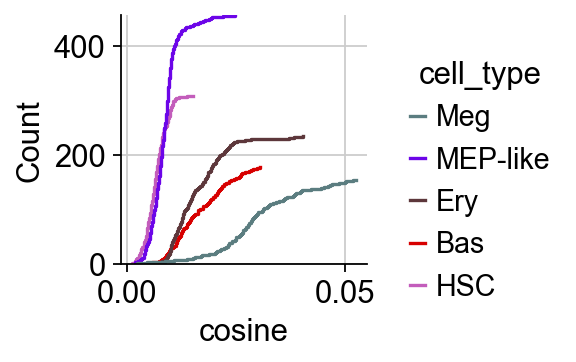

In [19]:
import seaborn as sns
df["cosine"] = potential_cosine[valid_indices]
df["fp"] = potential_fp[valid_indices]
sns.displot(
    data=df,
    x="cosine",
    hue="cell_type",
    kind="ecdf",
    stat="count",
    palette=dynamo_color_dict,
    height=2.5,
    aspect=95.5 / 88.8,
)
#plt.xlim(0.0, 0.008)
#plt.ylim(0, 12)
#plt.xlabel("vector field pseudotime")


Text(0.5, 12.355555555555553, 'vector field pseudotime')

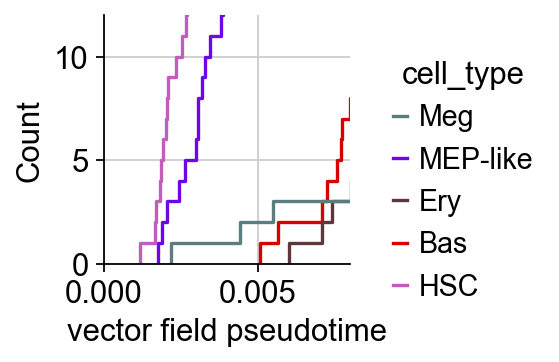

In [20]:
import matplotlib.pyplot as plt
sns.displot(
    data=df,
    x="cosine",
    hue="cell_type",
    kind="ecdf",
    stat="count",
    palette=dynamo_color_dict,
    height=2.5,
    aspect=95.5 / 88.8,
)
plt.xlim(0.0, 0.008)
plt.ylim(0, 12)
plt.xlabel("vector field pseudotime")


Via the visualization results above from vectorfield analysis, we can observe that egakaryocytes appear earliest among the Meg, Ery, and Bas lineages. 

## Molecular mechanisms underlying the early appearance of the Meg lineage

In this section, we will show:
- Self- activation of FLI1
- Repression of KLF1 by FLI1
- FLI1 represses KLF1
- Speed, acceleration and divergence calculation and visualization
- Schematic summarizing the interactions involving FLI1 and KLF1.

In [21]:
Meg_genes = ["FLI1", "KLF1"]

Compute jacobian of selected genes

In [22]:
dyn.vf.jacobian(adata_labeling, regulators=Meg_genes, effectors=Meg_genes)

Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 68442.71it/s]


AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'cosine_potential', 'potential_fp', 'pseudotime_fp'
    var: 'ge

Next we use jacobian analyses to reveal mutual inhibition between FLI1 and KLF1 (Figure 5F) and self-activation of FLI1.

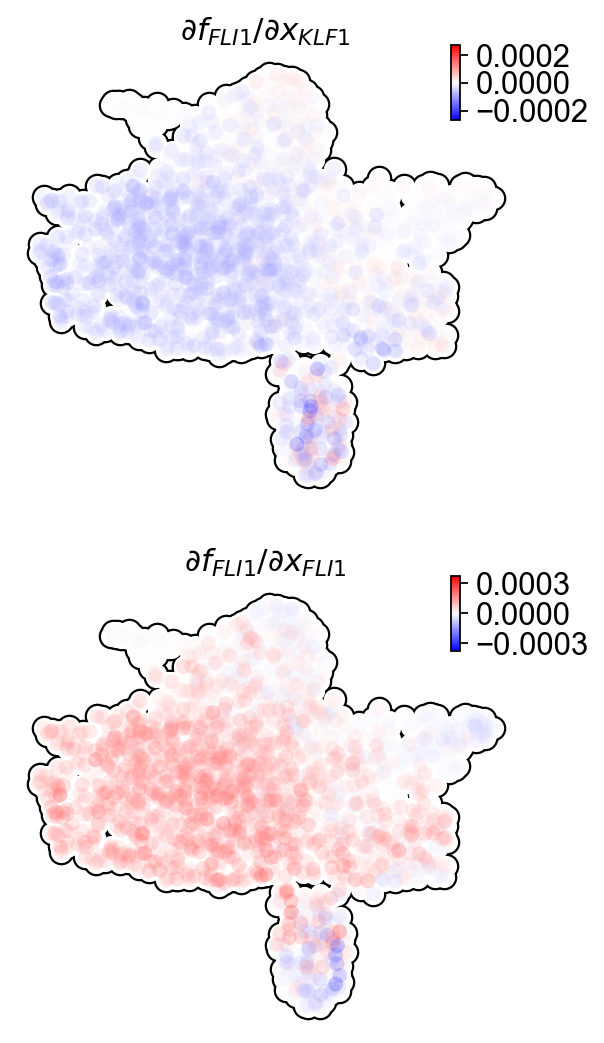

In [23]:
dyn.pl.jacobian(
    adata_labeling,
    regulators=Meg_genes,
    effectors=["FLI1"],
    basis="umap",
    figsize=(4,4)
)

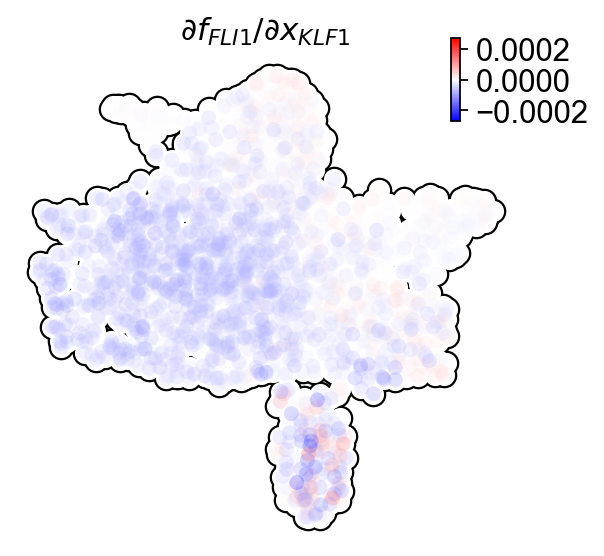

In [24]:
dyn.pl.jacobian(
    adata_labeling,
    regulators=["KLF1"],
    effectors=["FLI1"],
    basis="umap",
    figsize=(4,4)
)


Expression of FLI1 (Meg lineage master regulator) relative to KLF1 (Ery
lineage master regulator) in progenitors.

|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


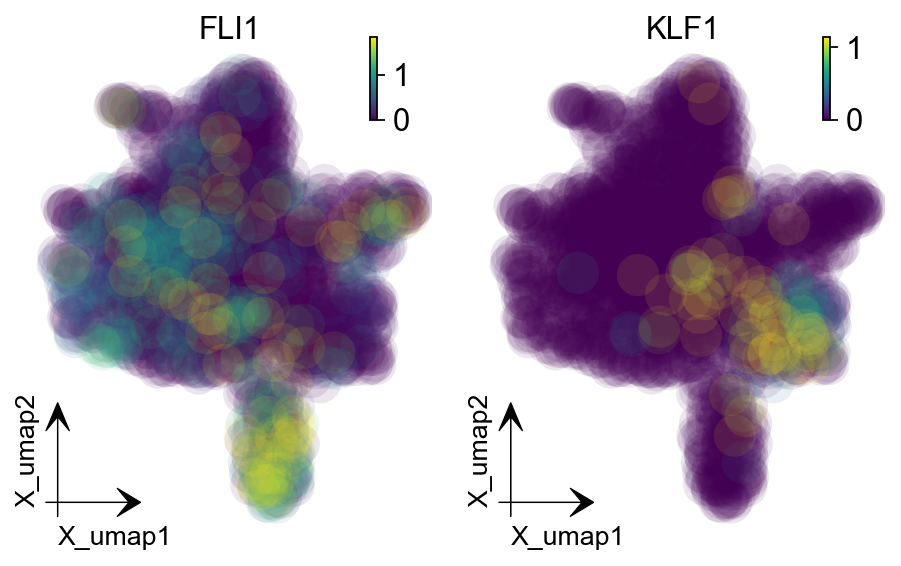

In [28]:
dyn.pl.umap(adata_labeling, 
            color=["FLI1", "KLF1"], 
            layer="X_total",figsize=(4,4),dpi=80,
           )


### Computing and visualizing speed, divergence, acceleration and curvature
In this subsection we will show that megakaryocytes have the largest RNA speed (velocitymagnitude) among all celltypes.
Same as our other published notebook usage examples, we can use methods from `dyn.vf` to calculate speed, divergence, acceleration and curvature within specific basis. In the following code cell, we select `pca` as the basis. 

In [29]:
basis = "pca"
dyn.vf.speed(adata_labeling, basis=basis)
dyn.vf.divergence(adata_labeling, basis=basis)
dyn.vf.acceleration(adata_labeling, basis=basis)
dyn.vf.curvature(adata_labeling, basis=basis)

|-----> [Calculating divergence with precomputed Jacobians] in progress: 100.0000%|-----> [Calculating divergence with precomputed Jacobians] completed [0.1374s]


Calculating divergence: 0it [00:00, ?it/s]


|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.1043s]
|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.1229s]
|-----> [Calculating curvature] in progress: 100.0000%|-----> [Calculating curvature] completed [0.0974s]


In [30]:
adata_labeling.obs["speed_" + basis][:5]

barcode
CCACAAGCGTGC-JL12_0    0.116313
CCATCCTGTGGA-JL12_0    0.410604
CCCTCGGCCGCA-JL12_0    0.086653
CCGCCCACCATG-JL12_0    0.145851
CCGCTGTGTAAG-JL12_0    0.096051
Name: speed_pca, dtype: float64

The results are saved to {quantity}_{basis} (e.g. ``speed_pca``). Then we can visualize via various visualization results.  
In the result below, we can observe the patterns of dynamics quantities including speed are consistent with the function of FLI1 (Meg lineage master regulator) and KLF1 (Ery
lineage master regulator).

|-----------> plotting with basis key=X_umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap


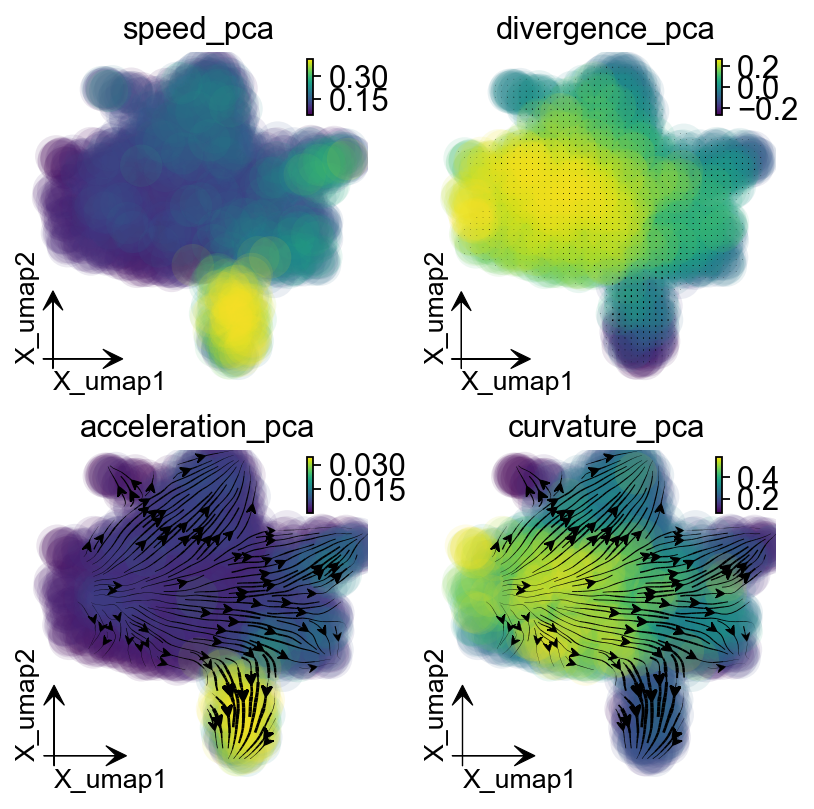

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(6, 6))
axes
dyn.pl.umap(adata_labeling, color="speed_" + basis, 
            ax=axes[0, 0], save_show_or_return="return")
dyn.pl.grid_vectors(
    adata_labeling,
    color="divergence_" + basis,
    ax=axes[0, 1],
    quiver_length=12,
    quiver_size=12,
    save_show_or_return="return",
)
dyn.pl.streamline_plot(adata_labeling, color="acceleration_" + basis, 
                       ax=axes[1, 0], save_show_or_return="return")
dyn.pl.streamline_plot(adata_labeling, color="curvature_" + basis,
                       ax=axes[1, 1], save_show_or_return="return")
plt.show()


### Conclusion: a schematic diagram summarizing the interactions involving FLI1 and KLF1
Analyses above collectively suggest self-activation of FLI1 maintains its higher expression in the HSPC state, which biases the HSPCs to first commit towards the Meg lineage with high speed and acceleration, while repressing the commitment into erythrocytes through inhibition of KLF1. Together with the mutual regulation we show ealier in this tutorial, we can generate the following schematic to summarize the gene    network. 



![fig5_f_iv](images/fig5_f_iv.png)